## Contents

1. [The Gutenberg dataset](#The-Gutenberg-dataset)
2. [Outlier removal](#Outlier-removal)
3. [A look at some coarse features](#A-look-at-some-coarse-features)
4. [Preprocessing](#Preprocessing)
5. [Cleaning](#Cleaning)
6. [Segment generation](#Segment-generation)
7. [Undersampling](#Undersampling)
8. [Bag-of-words representation](#Bag-of-words-representation)
9. [Ordinary least squares: A first attempt](#Ordinary-least-squares:-A-first-attempt)
10. [Classification: Changing the problem](#Classification:-Changing-the-problem)
11. [Reducing ambiguity](#Reducing-ambiguity)

In [ ]:
import csv
import pickle
import re
import os
import string

import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

## The Gutenberg dataset

Let's try to perform document regression on the (updated) [Gutenberg dataset](https://web.eecs.umich.edu/~lahiri/gutenberg_dataset.html), which consists of complete texts from over 3000 public domain books.

Unfortunately, these documents have already been stripped of metadata, including the year of publication. We attempt to resolve this issue by supposing that the first four-digit number appearing in each document (if any) is the date of publication.

The following loads texts for which a potential year of publication can be found into a dataframe. The texts are lowercased, stripped of all content up to and including the year (presumably front matter), and (importantly) stripped of the author's last name. First, we'll reset the notebook kernel to avoid potential namespace pollution.

In [31]:
%%time
text_dir = 'data/docs'
current_year = 2020

files = [file for file in os.listdir(text_dir) if '___' in file]

entries = []
for file in files:
    # author and title are embedded in the file name
    author, title = file.split('___')
    author = author.split()[-1]
    title = title.split('.txt')[0]
    
    with open(os.path.join(text_dir, file)) as f:
        text = f.read().lower()
        
        # search for the first occurence of a 4-digit number
        match = re.search('\d\d\d\d', text)
        
        if match:
            i = match.start()
            year = int(text[i:i+4])
            
            # remove front matter and author name
            text = text[i+5:].lower()
            text = re.sub(author.split()[-1].lower(), '', text)
            
            # filter out impossible years
            if year <= current_year:
                entries.append((author, title, year, text))

docs = pd.DataFrame(entries, columns=['author', 'title', 'year', 'text'])

CPU times: user 21.5 s, sys: 1.1 s, total: 22.6 s
Wall time: 27.6 s


The `docs` dataframe contains author, title, (estimated) year of publication, and full text.

In [32]:
docs.head()

,author,title,year,text
0,Kingsley,The Heroes,1889,\n _the right of translation ...
1,Wilde,Poems,1896,"\n\ni\n\nhe did not wear his scarlet coat,\nfo..."
2,Stevenson,The Works of Robert Louis Stevenson - Swanston...,1813,that i was so unlucky as to fall at last\ninto...
3,Alcott,On Picket Duty and Other Tales,1864,\n\n\n\non picket duty.\n\n\n_what_ air you th...
4,Melville,Israel Potter,1855,\n\n\n\ndedication\n\nto his highness the bunk...


The texts will need to be cleaned, but before we do that let's examine the year distribution. The plot below suggests an exponentially growing publication count throughout the years. This is actually quite reassuring in regards to our method for guessing publication date. However, this imbalance may be problematic later in our analysis and should be taken into account.

The sudden decrease in the number of publications in more recent years is likely explained by copyright law. The table shows the decrease beginning in the 1920s.

In [33]:
pd.DataFrame(docs.groupby('year').size().tail(25)).transpose()

year,1919,1920,1921,1922,1923,1924,1925,1927,1930,1932,...,1966,1967,1970,1972,1976,1980,1988,1991,2000,2006
0,29,30,26,26,3,2,1,1,2,1,...,2,1,1,1,2,1,1,2,16,1


The beginning of the histogram also contains an apparent anomaly, with a spike in publication count in the 11th century. As the table below shows, this is likely due to the disproportionate likelihood of the number 1000 appearing in a text.

We'll filter out this anomaly as well as the smaller number of publications after 1922.

In [34]:
pd.DataFrame(docs.groupby('year').size().head(10)).transpose()

year,1000,1001,1002,1007,1035,1050,1066,1090,1092,1099
0,10,3,1,2,2,2,2,1,1,2


In [35]:
docs = docs[(docs['year'] > 1000) & (docs['year'] < 1923)]

### Outlier removal

We still have some outliers to account for, as indicated in the box plot below.

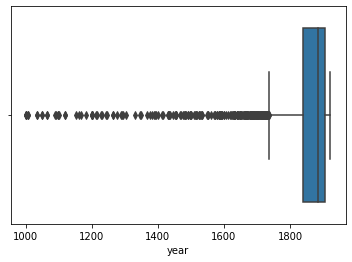

In [36]:
sns_data = sns.boxplot(docs['year'])

We'll restrict our attention to the range of years between the min and max whiskers. These can be computed from the interquartile range (the difference between the first and third quartiles).

In [37]:
iqr = docs['year'].quantile(0.75) - docs['year'].quantile(0.25)

start = docs['year'].quantile(0.25) - 1.5 * iqr
stop = docs['year'].quantile(0.75) + 1.5 * iqr

docs = docs[(docs['year'] > start) & (docs['year'] < stop)]

Within our selected range, the growth in the number of publications is much more regular.

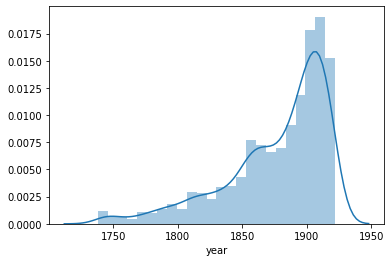

In [38]:
_ = sns.distplot(docs['year'])

## A look at some coarse features

In [39]:
# construct the features dataframe for later use
features = pd.DataFrame()
features['year'] = docs['year']
features['length'] = docs['text'].str.len()
features['words'] = docs['text'].map(lambda text: len(text.split()))
features['sentences'] = docs['text'].map(lambda text: len(text.split('.')))
features['commas'] = docs['text'].map(lambda text: len(text.split(',')))

In [40]:
features['avg word length'] = features['length'] / features['words']
features['avg sentence length'] = features['words'] / features['sentences']
features['avg commas'] = features['commas'] / features['words']

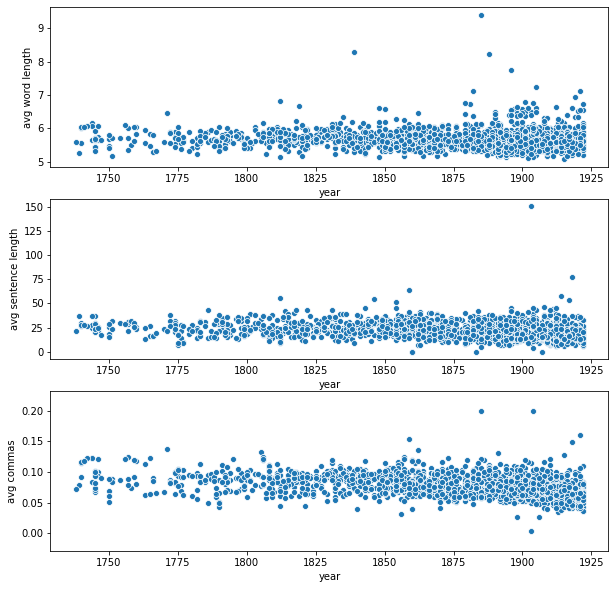

In [41]:
_, axs = plt.subplots(3, figsize=(10, 10))
sns.scatterplot(x='year', y='avg word length', data=features, ax=axs[0])
sns.scatterplot(x='year', y='avg sentence length', data=features, ax=axs[1])
_ = sns.scatterplot(x='year', y='avg commas', data=features, ax=axs[2])

These features don't appear to have terribly much predictive power. However, they are somewhat informative: they indicate potential [heteroscedasticity](https://en.wikipedia.org/wiki/Heteroscedasticity) in the data. This means that the variability of the data is correlated to the data itself. The gradual "spread" in time in the above scatter plots is a hallmark of heteroscedasticity. Since the spread is quite slight, it may not actually be an issue.

## Preprocessing

### Cleaning

Our main goal is to see if we can infer publication date from the words contained in a text. However, we might also conjecture that certain non-word features, such as punctuation density, may have some weight on our regression strategy.

The following first saves various punctuation statistics into a new dataframe and then cleans the texts, leaving only letters and white space. We filter out any remaining empty texts. Note that we didn't use Pandas' more concise [string methods](https://pandas.pydata.org/pandas-docs/stable/user_guide/text.html#string-methods) for this task, as we found them to be significantly slower.

In [42]:
%%time
docs['text'] = docs['text'].str.replace('[^a-z\s]', '').map(lambda text: ' '.join(text.split()))
docs = docs[docs['text'].map(len) > 0]

CPU times: user 51.6 s, sys: 6.09 s, total: 57.7 s
Wall time: 57.8 s


Here's an example of a cleaned text segment.

In [43]:
docs.loc[0, 'text'][:100]

'the right of translation if reserved printed by r r clark edinburgh to my children rose maurice and '

As we can see, we still have some front matter as well as named entities, which could potentially be used to date the document.

### Segment generation

We presently have on training example per document. However, different documents may have greatly differing lengths. The various features in our dataset may be normalized by the document length, however we may have further issues if working with methods that require fixed length inputs.

Below, we split each document into a number of text segments taken therefrom. This not only averts any of the potential issues mentioned above, but also artificially generates additional training data.

In [44]:
%%time
SEG_LENGTH = 1000

def split_text(text, seg_length=SEG_LENGTH):
    words = text.split()
    return [' '.join(words[i:i+seg_length]) for i in range(0, len(words), seg_length)]

segments = pd.DataFrame(docs[['year', 'text']])
segments['text'] = segments['text'].map(split_text)
segments = segments.explode('text').dropna()

CPU times: user 17 s, sys: 1.08 s, total: 18.1 s
Wall time: 18.1 s


### Undersampling

Let's also create an undersampled collection of text segments.  First, we'll organize the segments into decades.

In [45]:
segs = pd.DataFrame()
segs['year'] = segments['year']
segs['text'] = segments['text']
segs['decade'] = pd.cut(segments.year, range(segments['year'].min(), segments['year'].max(), 10))

Then we'll sample from each decade as many segments as possible while maintaining relative uniformity (i.e. as many samples as are contained in the decade with the fewest samples).

In [46]:
decade_min = segs.groupby('decade').size().min()
segs = segs.groupby('decade').apply(lambda df: df.sample(decade_min))

The new year distribution is quite flat.

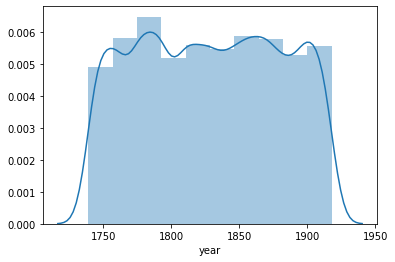

In [47]:
_ = sns.distplot(segs['year'], bins=10)

However, we've lost quite a lot of data.

In [48]:
print('{} total segments'.format(len(segments)))
print('{} undersampled segments'.format(len(segs)))

152564 total segments
16344 undersampled segments


## Bag-of-words representation

A more refined analysis can be obtained by using word frequencies as features. This can be done using a [bag-of-words model](https://en.wikipedia.org/wiki/Bag-of-words_model), in which a text is represented as a vector whose components components correspond to words in a vocabulary. The values of a component is a measure of the frequency of that word in the document.

Simply counting the number of occurences of a word is often a poor measure of frequency, as it may merely be indicative of text size (however, it is sensible in some situations, such as when performing classification with multinomial [naive Bayes](https://en.wikipedia.org/wiki/Naive_Bayes_classifier)). A better solution would be to scale by the total number of words in a text.

An even more sophisticated approach is to look at the frequency of a word in a text in comparison to its frequency  in a corpus of texts. This is accomplished by the [tf-idf](https://en.wikipedia.org/wiki/Tf%E2%80%93idf), or term frequency-inverse document frequency.

Note that we don't remove stop words below, which are known to be useful in stylometry.

In [49]:
%%time
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=100_000)
X = vectorizer.fit_transform(segs['text'])

CPU times: user 16.2 s, sys: 247 ms, total: 16.4 s
Wall time: 16.5 s


The resulting matrix `X` contains one row per text segment and each row has length equal to the vocabulary fit by the vectorizer (which results from our choice of `min_df`). Each row will act as an input variable.

In [50]:
print('Number of segments: {}\nVocabulary size: {}'.format(X.shape[0], X.shape[1]))

Number of segments: 16344
Vocabulary size: 100000


It's typical to shift and scale data prior to learning, but shifting will eliminate sparsity. Scaling could be useful, but our data is at least normalized for now, so we'll put that off.

Let's construct the target variables `y` from the corresponding publication dates and split `(X, y)` into training and test sets.

In [51]:
from sklearn.preprocessing import StandardScaler
X = StandardScaler(with_mean=False).fit_transform(X)

In [52]:
y = segs['year']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

## Ordinary least squares: A first attempt

Let's apply simple linear regression to our bag-of-words vectors.

In [53]:
%%time
from sklearn.linear_model import LinearRegression
linreg = LinearRegression()
linreg.fit(X_train, y_train)
linreg.score(X_test, y_test)

CPU times: user 10.9 s, sys: 95.4 ms, total: 11 s
Wall time: 5.58 s


0.6019674943117473

This isn't too good, but our representation and model are extremely simple. In fact, we're overfitting quite a lot, which isn't too surprising since our data is so high-dimensional. We'll try to get out of this in the two following ways:

* Feature selection via dimensional reduction or lasso regularization.
* Ensemble methods.

The $R^2$ is a rather crude metric; better understand our model with a scatter plot of predictions against true values.

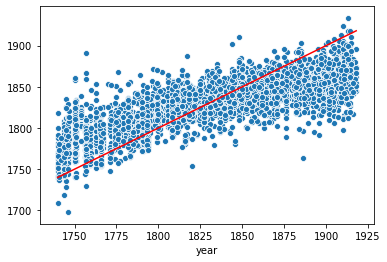

In [54]:
a = y_test.min()
b = y_test.max()
sns.lineplot([a, b], [a, b], color='r')
_ = sns.scatterplot(y_test, linreg.predict(X_test))

A perfect model would have all the points on the line $y = x$. Above, we see that, while our model appears to be correct *on average*, it makes quite a lot of mistakes: in fact, the spread of estimated years for a given true year appears to be almost a century.

## Classification: Changing the problem

Let's try an easier problem. We'll try to classify the time period of a document. We'll split our full range of dates by the median. Note that this resolves any data imbalance, so we can use the fully sampled `segments` dataframe.

In [55]:
X = vectorizer.fit_transform(segments['text'])

In [56]:
median = segments['year'].quantile()
y = segments['year']
t = y < median

We'll split `y` in addition to `X` and `t` so that we can analyze our classification errors later.

In [57]:
X_train, X_test, y_train, y_test, t_train, t_test = train_test_split(X, y, t, test_size=0.2)

Let's test a battery of simple classifiers to get an idea of the kind of performance we might expect. We'll start with logistic regression and a linear support vector machine.

In [58]:
%%time
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(solver='lbfgs', max_iter=500)
logreg.fit(X_train, t_train)
logreg.score(X_test, t_test)

CPU times: user 3min 2s, sys: 2.17 s, total: 3min 5s
Wall time: 1min 39s


0.8797561695015239

In [59]:
%%time
from sklearn.svm import LinearSVC

svm = LinearSVC()
svm.fit(X_train, t_train)
svm.score(X_test, t_test)

CPU times: user 14.6 s, sys: 692 ms, total: 15.3 s
Wall time: 16.3 s


0.9103660734768787

Let's have a look at the confusion matrix.

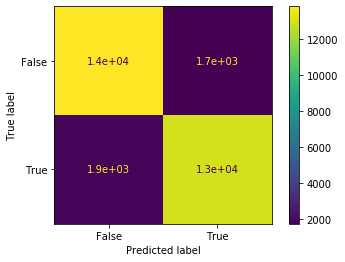

In [60]:
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(logreg, X_test, t_test)

We can also try a Naive Bayes classifier. In this case, it's natural to use a count vectorizer, which abstains from any kind of normalization, and to model the bag-of-word vectors as coming from a multinomial distribution.

In [61]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB

X_count = CountVectorizer(max_features=100_000).fit_transform(segments['text'])

X_count_train, X_count_test, t_train, t_test = train_test_split(X, t, test_size=0.2)

nb = MultinomialNB()
nb.fit(X_count_train, t_train)
nb.score(X_count_test, t_test)

0.8287287385704454

### Reducing ambiguity

Treating a regression problem as binary classification can have its downsides; after all, we're "forcing" the data into two groups when in fact a continuum of possibilities exists. In this case, we're creating a sharp distinction between "early" and "late" works. While a distinction is likely to exist, it's unlikely to be sharp. Thus, we're introducing classification errors from texts whose publication date may truly be ambiguous. Indeed, even a human expert would likely struggle with this problem.

Based on this, we would expect better classifcation performance when a greater divide between the two time periods is introduced. Below, we extract text segments from the first and fourth quartiles of our time range. This isn't merely simplifying the problem again; rather, we're treating a problem that is more natural.

In [62]:
p = segments['year'].quantile(0.25)
q = segments['year'].quantile(0.75)

split_segments = segments[(segments['year'] < p) | (segments['year'] > q)]

In [63]:
vectorizer = TfidfVectorizer(max_features=100_000)
X = vectorizer.fit_transform(split_segments['text'])
y = split_segments['year']
t = y < p

In [64]:
from sklearn.preprocessing import StandardScaler
X = StandardScaler(with_mean=False).fit_transform(X)

In [65]:
X_train, X_test, t_train, t_test = train_test_split(X, t, test_size=0.2)

In [66]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(max_iter=500)
logreg.fit(X_train, t_train)
logreg.score(X_test, t_test)

0.9444223107569721

In [67]:
from sklearn.svm import LinearSVC
svm = LinearSVC(max_iter=500)
svm.fit(X_train, t_train)
svm.score(X_test, t_test)

/home/ben/anaconda3/envs/tf/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


0.9312084993359894